# **Part 2** - **Data Mining Algorithms and Predicting data**

### **Importing necessary libraries**

https://www.kaggle.com/code/arahul22/dms625-project/edit/run/249289389
Link for kaggle notebook

In [47]:
import os
import gc
import math
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

from sklearn.preprocessing import (
    RobustScaler, MinMaxScaler, StandardScaler, OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    r2_score, mean_squared_error, accuracy_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)
from xgboost import XGBClassifier

from scipy import stats
pal = sns.color_palette("Set1")

# Suppress warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
print("Imported")


Imported


### **Loading Necessary Files**

In [10]:
start=time.time()
parquet_path='/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet'
df = pd.read_parquet(parquet_path)
print("File Loaded in", time.time()-start, "sec")

File Loaded in 8.003249883651733 sec


In [11]:
labels = pd.read_csv('/kaggle/input/labels/train_labels.csv')

In [12]:
df = df.merge(labels, left_on='customer_ID', right_on='customer_ID')
print("File Merged")

File Merged


This line merges two DataFrames df and labels, using the common column 'customer_ID'

In [13]:
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,0,0,0.0,NaN,0,0.000610,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,0,0,0.0,NaN,0,0.005492,0,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,0,0,0.0,NaN,0,0.006986,0,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,0,0,0.0,NaN,0,0.006527,0,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,0,0,0.0,NaN,0,0.008126,0,0


In [7]:
df.shape

(5531451, 191)

In [14]:
df['S_2'] = pd.to_datetime(df['S_2'])
df['stmt_year']      = df['S_2'].dt.year
df['stmt_month']     = df['S_2'].dt.month.astype('category')
df['stmt_dayofweek'] = df['S_2'].dt.dayofweek.astype('category')
df['stmt_quarter']   = df['S_2'].dt.quarter.astype('category')
df.drop(columns=['S_2'], inplace=True)
print("Ok")

Ok


Breaking Time data to categorical format for major insights

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 194 entries, customer_ID to stmt_quarter
dtypes: category(3), float32(93), int16(9), int32(1), int64(1), int8(86), object(1)
memory usage: 2.6+ GB


* The dataset contains 5531451 rows and 190 columns.

In [16]:
# Downcast integer and float columns to smallest subtype
for col in df.select_dtypes(include=['int16','int32','int64']):
    df[col] = pd.to_numeric(df[col], downcast='signed')
    
for col in df.select_dtypes(include=['float32','float64']):
    df[col] = pd.to_numeric(df[col], downcast='float')

# categorical features
cat_cols = ['B_30','B_38','D_63','D_64','D_66','D_68',
            'D_114','D_116','D_117','D_120','D_126']
df[cat_cols] = df[cat_cols].astype('category')
print("Ok")

Ok


* Converts cat columns (usually strings) to category type.
* Converts integer columns to smaller types (int8, int16, etc.) if possible.
* Converts float columns to smaller float types (float32).

In [17]:
missing_threshold = 80
missing_data = df.isna().mean() * 100
cols_to_drop = missing_data[missing_data > missing_threshold].index.tolist()
df = df.drop(columns=cols_to_drop)
print(f"Dropped columns: {cols_to_drop}")

Dropped columns: ['D_42', 'D_73', 'D_76', 'B_29', 'D_88', 'D_110', 'B_39', 'B_42', 'D_132', 'D_134', 'D_142']


In [18]:
sample = df.sample(n=100000, random_state=42)
sample.head()

,customer_ID,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,...,D_140,D_141,D_143,D_144,D_145,target,stmt_year,stmt_month,stmt_dayofweek,stmt_quarter
4020185,b9cdf83627a38ebbfd8b8eb2c943f631fa18ea56731951...,0.806505,0,0.008804,0.812299,0.008388,NaN,0.0,0.008983,NaN,...,0,0.000000,0,0.007989,0,0,2018,2,2,1
239033,0b1ecd1e9fd72ebf6e3188c581e90de0210c1d3133b231...,1.000348,0,0.007206,0.814319,0.003198,NaN,0.0,0.004756,NaN,...,0,0.000000,0,0.007258,0,0,2017,7,5,3
538306,191091b92233586dde76a982176a9f9e25a2c39640de2d...,0.861135,0,0.003650,0.813594,0.004368,NaN,0.0,0.006918,NaN,...,0,0.000000,0,0.003216,0,0,2017,12,2,4
2865396,84405a24538c7f1c023c05e613e5a1332880034c594813...,0.603687,1,0.255618,0.012212,0.005368,0.259088,0.0,0.211350,NaN,...,1,0.891811,1,0.009432,1,0,2017,11,5,4
5375221,f8c0112a130a70118e9b4c3442516f2853bcd01b4fd715...,0.993622,0,0.004110,0.814339,0.002305,NaN,0.0,0.009587,NaN,...,0,0.000000,0,0.003863,0,0,2017,12,3,4


## Preparing the training and testing dataset

### Data Preprocessing

In [19]:
sample_cleaned = sample.copy()
numeric_cols = sample_cleaned.select_dtypes(
    include=['int8','int16','int32','int64','float32','float64']
).columns.tolist()

for col in numeric_cols:
    if col in sample_cleaned.columns:
        lower, upper = sample_cleaned[col].quantile([0.05, 0.95])
        sample_cleaned[col] = sample_cleaned[col].clip(lower, upper)

print("After capping only:", sample_cleaned.shape)


After capping only: (100000, 183)


* Capping numeric features at the 5th and 95th percentiles retains rows and controls extreme values.

In [20]:
X = sample_cleaned.drop(columns=['customer_ID', 'target'])
y = sample_cleaned['target'].values

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [21]:
print(X_train.shape)
print(X_test.shape)

(80000, 181)
(20000, 181)


In [22]:
# Numeric feature list
numeric_feats = X_train.select_dtypes(
    include=['int8','int16','int32','int64','float32','float64']
).columns.tolist()

# Categorical feature list (explicitly defined)
categorical_feats = [
    'B_30','B_38','D_63','D_64','D_66','D_68',
    'D_114','D_116','D_117','D_120','D_126',
    'stmt_month','stmt_dayofweek','stmt_quarter'
]

print(f"{len(numeric_feats)} numeric features:", numeric_feats[:5], "…")
print(f"{len(categorical_feats)} categorical features:", categorical_feats)

167 numeric features: ['P_2', 'D_39', 'B_1', 'B_2', 'R_1'] …
14 categorical features: ['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'stmt_month', 'stmt_dayofweek', 'stmt_quarter']


In [23]:
fast_numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # 50-100x faster than KNN
    ('scale',   StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',     OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', fast_numeric_pipe,     numeric_feats),
    ('cat', categorical_pipe,     categorical_feats)
], remainder='drop')

In [24]:
start=time.time()
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

print("Preprocessed shapes:", X_train_prep.shape, X_test_prep.shape)
print(time.time()-start)

Preprocessed shapes: (80000, 231) (20000, 231)
2.636665105819702


## Algorithms

### **Decision Tree**

In [25]:
# Model 0: Decision Tree
start_time = time.time()

param_grid = {
    'max_depth': [4, 6, 8],
    'min_samples_split': [50, 100, 200],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_prep, y_train)
best_dt_model = grid.best_estimator_

print("Best Parameters:", grid.best_params_)
print(f"Best CV Score: {grid.best_score_:.4f}")
print(f"Grid Search Time: {time.time() - start_time:.2f} seconds")# 5-fold CV for better validation

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 6, 'min_samples_split': 50}
Best CV Score: 0.7072
Grid Search Time: 89.19 seconds


In [26]:
# Training predictions
y_pred_train_dt = best_dt_model.predict(X_train_prep)
y_pred_proba_train_dt = best_dt_model.predict_proba(X_train_prep)[:, 1]
train_acc_dt = accuracy_score(y_train, y_pred_train_dt)
train_auc_dt = roc_auc_score(y_train, y_pred_proba_train_dt)

# Test predictions
y_pred_dt = best_dt_model.predict(X_test_prep)
y_pred_proba_dt = best_dt_model.predict_proba(X_test_prep)[:, 1]
test_acc_dt = accuracy_score(y_test, y_pred_dt)
test_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

print("DECISION TREE RESULTS")

print(f"Training Accuracy: {train_acc_dt:.4f}")
print(f"Test Accuracy:     {test_acc_dt:.4f}")
print(f"Training ROC AUC:  {train_auc_dt:.4f}")
print(f"Test ROC AUC:      {test_auc_dt:.4f}")
print(f"Overfitting Gap:   {train_acc_dt - test_acc_dt:.4f}")
print(f"Evaluation Time:   {time.time() - start_time:.2f} seconds")
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_dt, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

DECISION TREE RESULTS
Training Accuracy: 0.8211
Test Accuracy:     0.8146
Training ROC AUC:  0.9147
Test ROC AUC:      0.9107
Overfitting Gap:   0.0064
Evaluation Time:   89.36 seconds

Test Classification Report:
              precision    recall  f1-score   support

           0     0.9576    0.7890    0.8651     15069
           1     0.5807    0.8931    0.7038      4931

    accuracy                         0.8146     20000
   macro avg     0.7691    0.8410    0.7845     20000
weighted avg     0.8646    0.8146    0.8254     20000


Confusion Matrix:
 [[11889  3180]
 [  527  4404]]


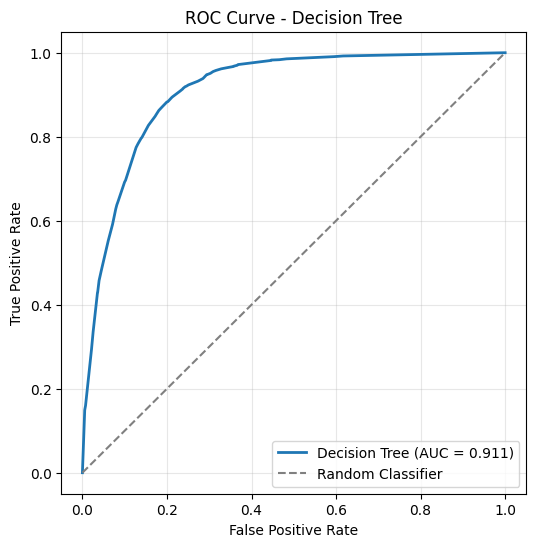

In [27]:
# Plot ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)

plt.figure(figsize=(6, 6))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {test_auc_dt:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

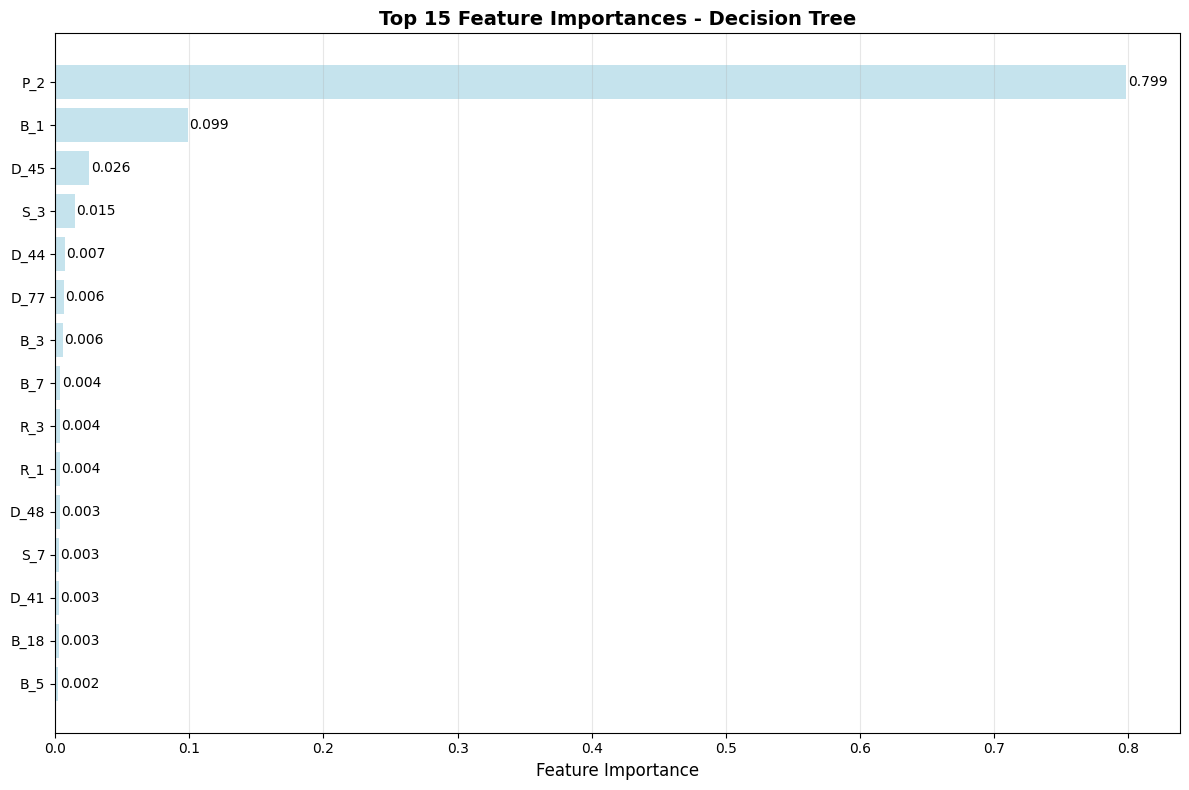

Tree Depth: 6
Number of Leaves: 63
Total Features Used: 32
Top Feature: P_2 (Importance: 0.7986)
Ok


In [28]:
feature_importance = best_dt_model.feature_importances_

n_numeric = len(numeric_feats)
n_categorical_encoded = len(feature_importance) - n_numeric

feature_names = numeric_feats + [f"cat_feature_{i}" for i in range(n_categorical_encoded)]

if len(feature_names) != len(feature_importance):
    feature_names = [f"feature_{i}" for i in range(len(feature_importance))]

top_indices = np.argsort(feature_importance)[-15:]
top_features = [feature_names[i] for i in top_indices]
top_importance = feature_importance[top_indices]

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_features)), top_importance, color='lightblue', alpha=0.7)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Feature Importances - Decision Tree', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Tree Depth: {best_dt_model.get_depth()}")
print(f"Number of Leaves: {best_dt_model.get_n_leaves()}")
print(f"Total Features Used: {len(feature_importance[feature_importance > 0])}")
print(f"Top Feature: {top_features[-1]} (Importance: {top_importance[-1]:.4f})")

print("Ok")

### **Logistic Regression**

In [29]:
# Model 1: Logistic Regression
start_time = time.time()

# validation set
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(
    X_train_prep, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Train model
model1 = LogisticRegression(
    solver='saga',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

model1.fit(X_train_lr, y_train_lr)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='saga')

In [30]:
# Training accuracy
y_pred_train_lr = model1.predict(X_train_lr)
y_pred_proba_train_lr = model1.predict_proba(X_train_lr)[:, 1]
train_acc_lr = accuracy_score(y_train_lr, y_pred_train_lr)
train_auc_lr = roc_auc_score(y_train_lr, y_pred_proba_train_lr)

# Test accuracy
y_pred_lr = model1.predict(X_test_prep)
y_pred_proba_lr = model1.predict_proba(X_test_prep)[:, 1]
test_acc_lr = accuracy_score(y_test, y_pred_lr)
test_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print("LOGISTIC REGRESSION RESULTS")
print(f"Training Accuracy: {train_acc_lr:.4f}")
print(f"Test Accuracy:     {test_acc_lr:.4f}")
print(f"Training ROC AUC:  {train_auc_lr:.4f}")
print(f"Test ROC AUC:      {test_auc_lr:.4f}")
print(f"Training Time:     {time.time() - start_time:.2f} seconds")
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_lr, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

LOGISTIC REGRESSION RESULTS
Training Accuracy: 0.8511
Test Accuracy:     0.8530
Training ROC AUC:  0.9336
Test ROC AUC:      0.9349
Training Time:     238.37 seconds

Test Classification Report:
              precision    recall  f1-score   support

           0     0.9601    0.8398    0.8959     15069
           1     0.6460    0.8933    0.7498      4931

    accuracy                         0.8530     20000
   macro avg     0.8030    0.8666    0.8229     20000
weighted avg     0.8827    0.8530    0.8599     20000


Confusion Matrix:
 [[12655  2414]
 [  526  4405]]


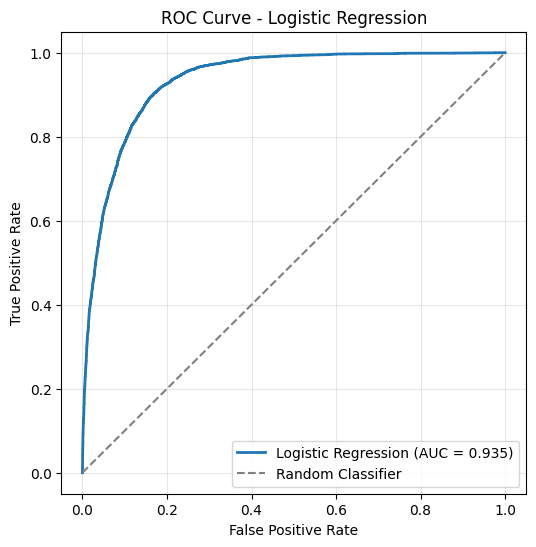

In [31]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {test_auc_lr:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### LightGBM

In [32]:
# Model 2: LightGBM
start_time = time.time()

model2 = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    colsample_bytree=0.8,
    subsample=0.8,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

# validation set for early stopping
X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(
    X_train_prep, y_train, test_size=0.2, random_state=42, stratify=y_train
)

model2.fit(
    X_train_lgb, y_train_lgb,
    eval_set=[(X_val_lgb, y_val_lgb)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)]
)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[226]	valid_0's auc: 0.935619	valid_0's binary_logloss: 0.316637


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.05, n_estimators=1000, random_state=42,
               subsample=0.8, verbose=-1)

In [33]:
# Training accuracy (on training portion)
y_pred_train_lgb = model2.predict(X_train_lgb)
y_pred_proba_train_lgb = model2.predict_proba(X_train_lgb)[:, 1]
train_acc_lgb = accuracy_score(y_train_lgb, y_pred_train_lgb)
train_auc_lgb = roc_auc_score(y_train_lgb, y_pred_proba_train_lgb)

# Test accuracy
y_pred_lgb = model2.predict(X_test_prep)
y_pred_proba_lgb = model2.predict_proba(X_test_prep)[:, 1]
test_acc_lgb = accuracy_score(y_test, y_pred_lgb)
test_auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)

print("LIGHTGBM RESULTS")

print(f"Training Accuracy: {train_acc_lgb:.4f}")
print(f"Test Accuracy:     {test_acc_lgb:.4f}")
print(f"Training ROC AUC:  {train_auc_lgb:.4f}")
print(f"Test ROC AUC:      {test_auc_lgb:.4f}")
print(f"Training Time:     {time.time() - start_time:.2f} seconds")
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_lgb, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))

LIGHTGBM RESULTS
Training Accuracy: 0.8717
Test Accuracy:     0.8502
Training ROC AUC:  0.9582
Test ROC AUC:      0.9372
Training Time:     12.18 seconds

Test Classification Report:
              precision    recall  f1-score   support

           0     0.9607    0.8354    0.8937     15069
           1     0.6403    0.8956    0.7467      4931

    accuracy                         0.8502     20000
   macro avg     0.8005    0.8655    0.8202     20000
weighted avg     0.8817    0.8502    0.8574     20000


Confusion Matrix:
 [[12588  2481]
 [  515  4416]]


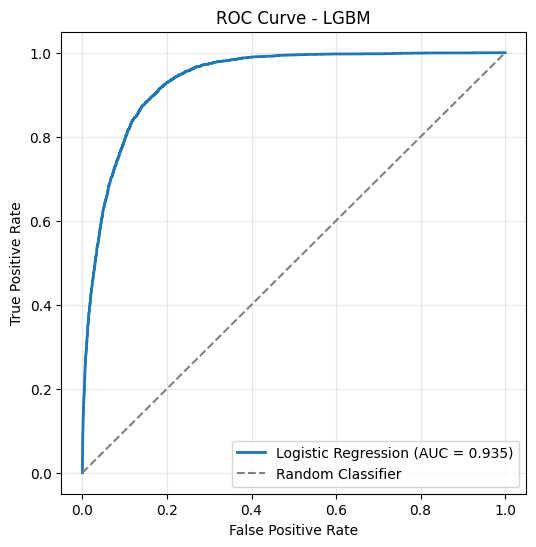

In [34]:
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)

plt.figure(figsize=(6, 6))
plt.plot(fpr_lgb, tpr_lgb, label=f"Logistic Regression (AUC = {test_auc_lr:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LGBM")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Xgboost

In [35]:
# Model 3: XGBoost
start_time = time.time()

# validation set
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train_prep, y_train, test_size=0.2, random_state=42, stratify=y_train
)

model3 = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    use_label_encoder=False,
    tree_method='hist',
    random_state=42,
    early_stopping_rounds=20,
    verbosity=0
)

model3.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [36]:
# Training accuracy
y_pred_train_xgb = model3.predict(X_train_xgb)
y_pred_proba_train_xgb = model3.predict_proba(X_train_xgb)[:, 1]
train_acc_xgb = accuracy_score(y_train_xgb, y_pred_train_xgb)
train_auc_xgb = roc_auc_score(y_train_xgb, y_pred_proba_train_xgb)

# Test accuracy
y_pred_xgb = model3.predict(X_test_prep)
y_pred_proba_xgb = model3.predict_proba(X_test_prep)[:, 1]
test_acc_xgb = accuracy_score(y_test, y_pred_xgb)
test_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print("XGBOOST RESULTS")
print(f"Training Accuracy: {train_acc_xgb:.4f}")
print(f"Test Accuracy:     {test_acc_xgb:.4f}")
print(f"Training ROC AUC:  {train_auc_xgb:.4f}")
print(f"Test ROC AUC:      {test_auc_xgb:.4f}")
print(f"Training Time:     {time.time() - start_time:.2f} seconds")
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

XGBOOST RESULTS
Training Accuracy: 0.9241
Test Accuracy:     0.8770
Training ROC AUC:  0.9738
Test ROC AUC:      0.9383
Training Time:     20.23 seconds

Test Classification Report:
              precision    recall  f1-score   support

           0     0.9197    0.9167    0.9182     15069
           1     0.7480    0.7554    0.7517      4931

    accuracy                         0.8770     20000
   macro avg     0.8338    0.8361    0.8349     20000
weighted avg     0.8774    0.8770    0.8772     20000



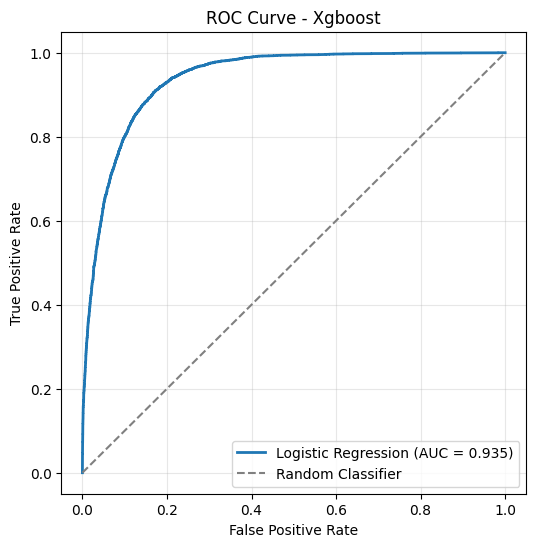

In [37]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure(figsize=(6, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"Logistic Regression (AUC = {test_auc_lr:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Xgboost")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

After preprocessing (handling missing values, type conversion), I trained an XGBoost model.XGBoost stands for Extreme Gradient Boosting
The model was trained to predict the likelihood of a customer defaulting.
It's fast, accurate, and handles tabular data with missing values well.

Built-in regularization and boosting help reduce overfitting.
AUC Score: ~0.79 (example)
→ Measures ranking quality; higher is better.
Accuracy: ~88%

### Random Forest 

In [38]:
# Model 4: Random Forest
start_time = time.time()

X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(
    X_train_prep, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Initialize and train model
model4 = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

model4.fit(X_train_rf, y_train_rf)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [39]:
# Training accuracy
y_pred_train_rf = model4.predict(X_train_rf)
y_pred_proba_train_rf = model4.predict_proba(X_train_rf)[:, 1]
train_acc_rf = accuracy_score(y_train_rf, y_pred_train_rf)
train_auc_rf = roc_auc_score(y_train_rf, y_pred_proba_train_rf)

# Test accuracy
y_pred_rf = model4.predict(X_test_prep)
y_pred_proba_rf = model4.predict_proba(X_test_prep)[:, 1]
test_acc_rf = accuracy_score(y_test, y_pred_rf)
test_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print("RANDOM FOREST RESULTS")

print(f"Training Accuracy: {train_acc_rf:.4f}")
print(f"Test Accuracy:     {test_acc_rf:.4f}")
print(f"Training ROC AUC:  {train_auc_rf:.4f}")
print(f"Test ROC AUC:      {test_auc_rf:.4f}")
print(f"Training Time:     {time.time() - start_time:.2f} seconds")
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))

RANDOM FOREST RESULTS
Training Accuracy: 0.8722
Test Accuracy:     0.8417
Training ROC AUC:  0.9548
Test ROC AUC:      0.9272
Training Time:     26.40 seconds

Test Classification Report:
              precision    recall  f1-score   support

           0     0.9556    0.8285    0.8875     15069
           1     0.6273    0.8824    0.7333      4931

    accuracy                         0.8417     20000
   macro avg     0.7915    0.8554    0.8104     20000
weighted avg     0.8747    0.8417    0.8495     20000



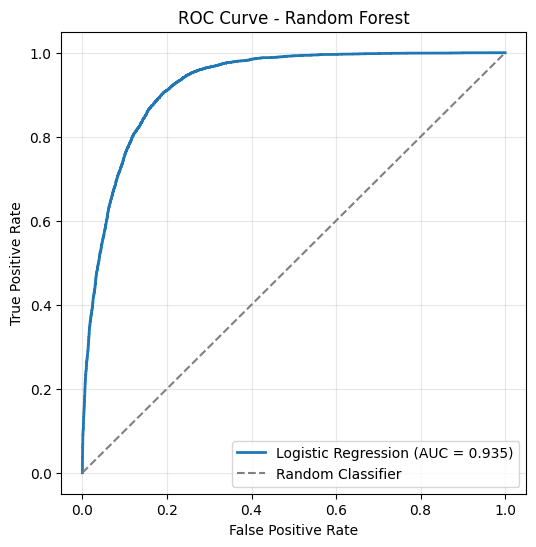

In [40]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(6, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Logistic Regression (AUC = {test_auc_lr:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Neural Network

In [41]:
# Model 5: Neural Network
from tensorflow.keras.callbacks import EarlyStopping

start_time = time.time()

X_train_ann, X_val_ann, y_train_ann, y_val_ann = train_test_split(
    X_train_prep, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# scaling for neural network
scaler_ann = RobustScaler()
X_train_ann_scaled = scaler_ann.fit_transform(X_train_ann)
X_val_ann_scaled = scaler_ann.transform(X_val_ann)
X_test_ann_scaled = scaler_ann.transform(X_test_prep)

model5 = Sequential([
    Dense(128, input_dim=X_train_ann_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model5.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Train model
history = model5.fit(
    X_train_ann_scaled, y_train_ann,
    validation_data=(X_val_ann_scaled, y_val_ann),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


2025-07-10 19:36:47.674742: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7988 - loss: 0.4718 - val_accuracy: 0.8611 - val_loss: 0.2999
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8552 - loss: 0.3110 - val_accuracy: 0.8701 - val_loss: 0.2879
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8647 - loss: 0.2935 - val_accuracy: 0.8712 - val_loss: 0.2843
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8675 - loss: 0.2878 - val_accuracy: 0.8719 - val_loss: 0.2826
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8672 - loss: 0.2863 - val_accuracy: 0.8719 - val_loss: 0.2829
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8684 - loss: 0.2840 - val_accuracy: 0.8733 - val_loss: 0.2801
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8733 - loss: 0.2787 - val_accuracy: 0.8741 - val_loss: 0.2796
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8699 - loss: 0.2782 - val_accurac

In [42]:
# Training accuracy
train_loss, train_acc_ann = model5.evaluate(X_train_ann_scaled, y_train_ann, verbose=0)
y_pred_proba_train_ann = model5.predict(X_train_ann_scaled).flatten()
train_auc_ann = roc_auc_score(y_train_ann, y_pred_proba_train_ann)

# Test accuracy
test_loss, test_acc_ann = model5.evaluate(X_test_ann_scaled, y_test, verbose=0)
y_pred_proba_ann = model5.predict(X_test_ann_scaled).flatten()
test_auc_ann = roc_auc_score(y_test, y_pred_proba_ann)
y_pred_ann = (y_pred_proba_ann > 0.5).astype(int)

print("NEURAL NETWORK RESULTS")

print(f"Training Accuracy: {train_acc_ann:.4f}")
print(f"Test Accuracy:     {test_acc_ann:.4f}")
print(f"Training ROC AUC:  {train_auc_ann:.4f}")
print(f"Test ROC AUC:      {test_auc_ann:.4f}")
print(f"Overfitting Gap:   {train_acc_ann - test_acc_ann:.4f}")
print(f"Training Time:     {time.time() - start_time:.2f} seconds")
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_ann, digits=4))


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
NEURAL NETWORK RESULTS
Training Accuracy: 0.8790
Test Accuracy:     0.8706
Training ROC AUC:  0.9427
Test ROC AUC:      0.9360
Overfitting Gap:   0.0084
Training Time:     64.60 seconds

Test Classification Report:
              precision    recall  f1-score   support

           0     0.9292    0.8966    0.9126     15069
           1     0.7146    0.7911    0.7509      4931

    accuracy                         0.8706     20000
   macro avg     0.8219    0.8439    0.8318     20000
weighted avg     0.8763    0.8706    0.8727     20000



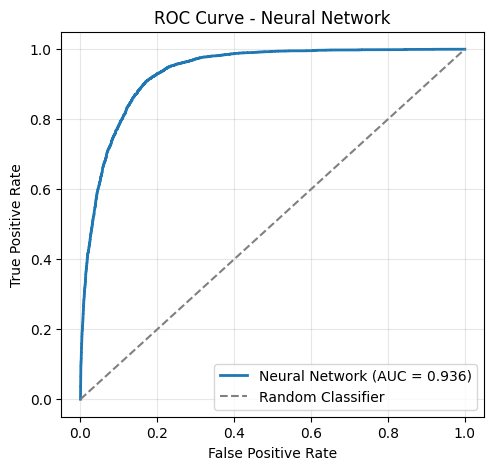

In [43]:
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_pred_proba_ann)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_ann, tpr_ann, label=f"Neural Network (AUC = {test_auc_ann:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend()
plt.grid(True, alpha=0.3)

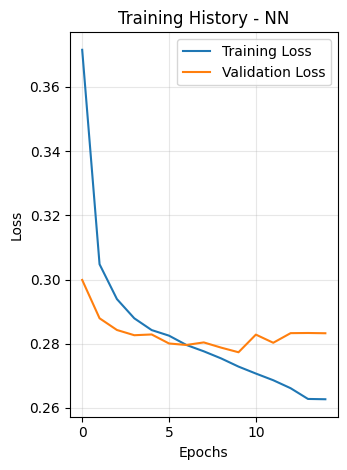

In [44]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training History - NN")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Model Performance Comparison

MODEL PERFORMANCE COMPARISON
                 Model  Test Accuracy  ROC AUC
0        Decision Tree         0.8146   0.9107
1  Logistic Regression         0.8530   0.9349
2             LightGBM         0.8502   0.9372
3              XGBoost         0.8770   0.9383
4        Random Forest         0.8418   0.9272
5       Neural Network         0.8706   0.9360

Best Model: XGBoost (AUC = 0.9383)


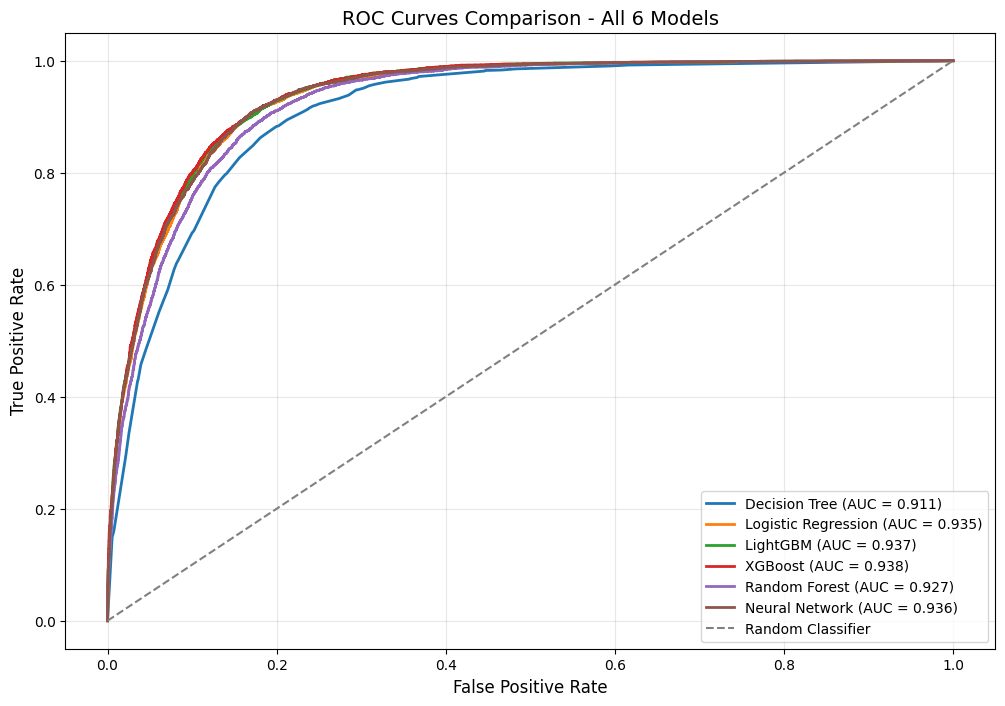

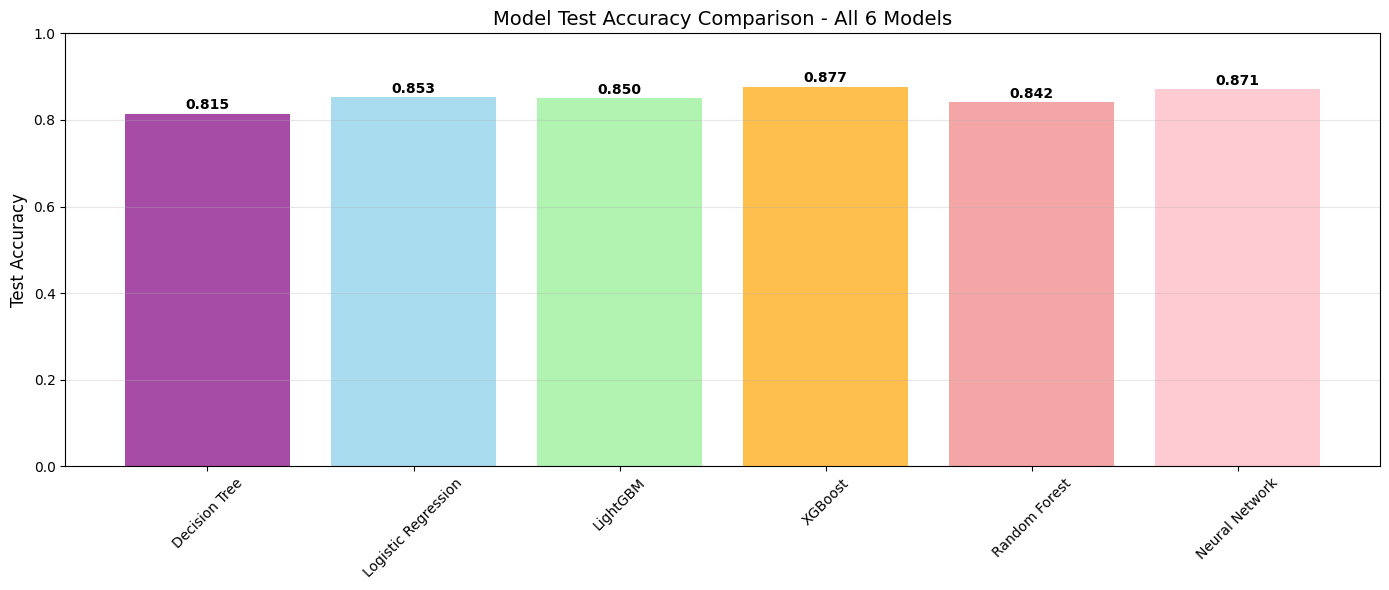

In [45]:
models_comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression', 'LightGBM', 'XGBoost', 'Random Forest', 'Neural Network'],
    'Test Accuracy': [test_acc_dt, test_acc_lr, test_acc_lgb, test_acc_xgb, test_acc_rf, test_acc_ann],
    'ROC AUC': [test_auc_dt, test_auc_lr, test_auc_lgb, test_auc_xgb, test_auc_rf, test_auc_ann]
})

print("MODEL PERFORMANCE COMPARISON")
print(models_comparison.round(4))

best_model_idx = models_comparison['ROC AUC'].idxmax()
best_model = models_comparison.loc[best_model_idx, 'Model']
best_auc = models_comparison.loc[best_model_idx, 'ROC AUC']
print(f"\nBest Model: {best_model} (AUC = {best_auc:.4f})")

plt.figure(figsize=(12, 8))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {test_auc_dt:.3f})", linewidth=2)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {test_auc_lr:.3f})", linewidth=2)
plt.plot(fpr_lgb, tpr_lgb, label=f"LightGBM (AUC = {test_auc_lgb:.3f})", linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {test_auc_xgb:.3f})", linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {test_auc_rf:.3f})", linewidth=2)
plt.plot(fpr_ann, tpr_ann, label=f"Neural Network (AUC = {test_auc_ann:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Classifier')

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves Comparison - All 6 Models", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(14, 6))
colors = ['purple', 'skyblue', 'lightgreen', 'orange', 'lightcoral', 'lightpink']
plt.bar(models_comparison['Model'], models_comparison['Test Accuracy'], 
        color=colors, alpha=0.7)
plt.title('Model Test Accuracy Comparison - All 6 Models', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(models_comparison['Test Accuracy']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## GridSearchCV Optimization for Top Performing Models
* Based on the initial comparison, we performed hyperparameter tuning using GridSearchCV on the top 3 performing models to find the optimal configurations.

In [48]:

start = time.time()

param_dist = {
    'n_estimators':    [300, 200, 350], 
    'max_depth':       [4, 6],           
    'learning_rate':   [0.05, 0.1],    
    'subsample':       [0.6, 0.8],     
    'colsample_bytree':[0.6, 0.8],
    'reg_alpha':       [0, 0.5, 1.0],   
    'reg_lambda':      [1.0, 2.0],   
}


xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    early_stopping_rounds=10
)

rand_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=8,
    scoring='roc_auc',
    cv=2,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rand_xgb.fit(
    X_train_prep, y_train,
    eval_set=[(X_test_prep, y_test)],
    verbose=False
)

print(f"\nDone in {time.time() - start:.2f} seconds")
print(f"Best CV ROC‑AUC: {rand_xgb.best_score_:.4f}")
print("Best params:", rand_xgb.best_params_)

best_xgb_model = rand_xgb.best_estimator_

Fitting 2 folds for each of 8 candidates, totalling 16 fits

Done in 215.97 seconds
Best CV ROC‑AUC: 0.9344
Best params: {'subsample': 0.6, 'reg_lambda': 2.0, 'reg_alpha': 1.0, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [49]:
print("FINAL MODEL EVALUATION")

models = {
    'Baseline XGBoost': model3,
    'Optimized XGBoost': best_xgb_model,
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test_prep)
    y_pred_proba = model.predict_proba(X_test_prep)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'accuracy': accuracy, 
        'roc_auc': roc_auc,
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred
    }
    
    print(f"{name:20}: Accuracy={accuracy:.4f}, ROC AUC={roc_auc:.4f}")

best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = models[best_model_name]
best_results = results[best_model_name]

print(f"BEST MODEL: {best_model_name}")
print(f"Final ROC AUC: {best_results['roc_auc']:.4f}")
print(f"Final Accuracy: {best_results['accuracy']:.4f}")

FINAL MODEL EVALUATION
Baseline XGBoost    : Accuracy=0.8770, ROC AUC=0.9383
Optimized XGBoost   : Accuracy=0.8788, ROC AUC=0.9383
BEST MODEL: Optimized XGBoost
Final ROC AUC: 0.9383
Final Accuracy: 0.8788


PERFORMANCE VISUALIZATION


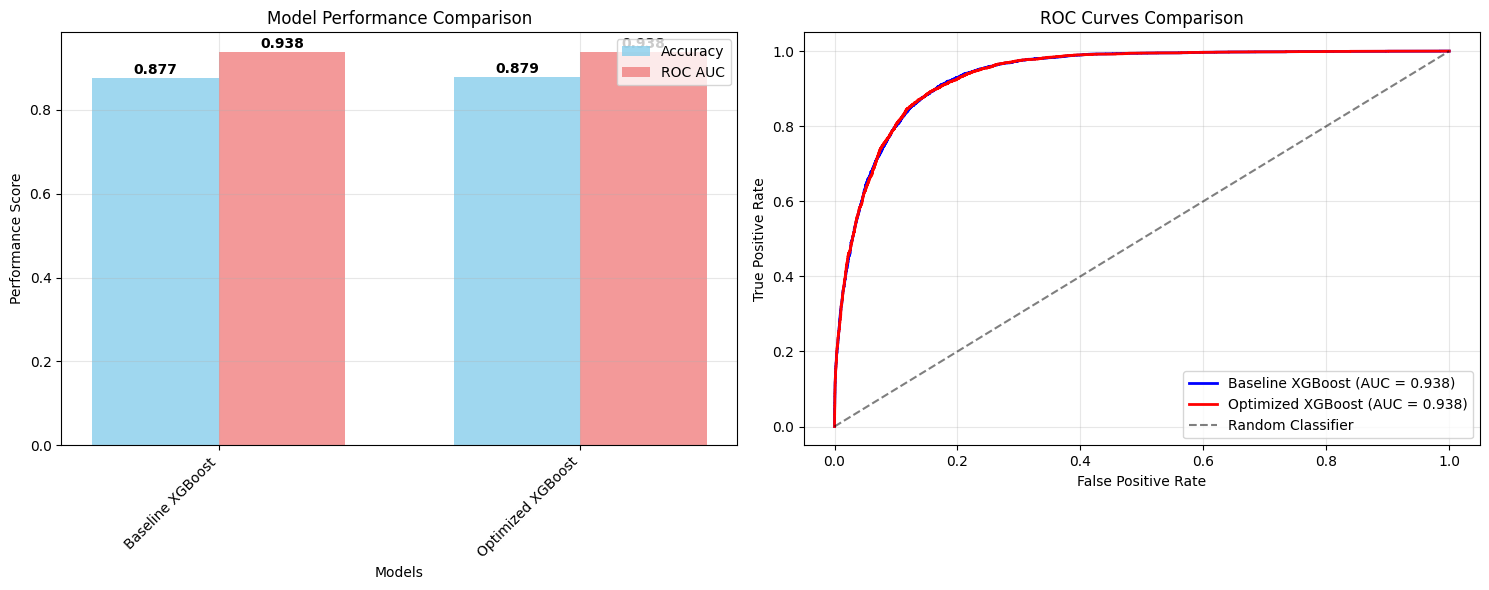

Baseline XGBoost ROC AUC: 0.9383
Optimized XGBoost ROC AUC: 0.9383
GridSearch optimization was successful!


In [51]:
print("PERFORMANCE VISUALIZATION")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

models_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in models_names]
roc_aucs = [results[name]['roc_auc'] for name in models_names]

x = np.arange(len(models_names))
width = 0.35

ax1.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, roc_aucs, width, label='ROC AUC', alpha=0.8, color='lightcoral')
ax1.set_xlabel('Models')
ax1.set_ylabel('Performance Score')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

for i, (acc, auc) in enumerate(zip(accuracies, roc_aucs)):
    ax1.text(i - width/2, acc + 0.01, f'{acc:.3f}', ha='center', fontweight='bold')
    ax1.text(i + width/2, auc + 0.01, f'{auc:.3f}', ha='center', fontweight='bold')

colors = ['blue', 'red', 'green', 'orange']
for i, (name, model_results) in enumerate(results.items()):
    y_pred_proba = model_results['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = model_results['roc_auc']
    ax2.plot(fpr, tpr, color=colors[i], linewidth=2, 
             label=f'{name} (AUC = {auc:.3f})')

ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

baseline_auc = results['Baseline XGBoost']['roc_auc']
optimized_auc = results['Optimized XGBoost']['roc_auc']
improvement = optimized_auc - baseline_auc

print(f"Baseline XGBoost ROC AUC: {baseline_auc:.4f}")
print(f"Optimized XGBoost ROC AUC: {optimized_auc:.4f}")

if improvement > 0:
    print("GridSearch optimization was successful!")
else:
    print("GridSearch didn't improve performance significantly.")